In [1]:
"""
    Script to stream news articles and compare sentiment against cryptocurrency price
    Author: Ross MacWilliam
    Date: 01/02/2021
"""


import pandas as pd
import numpy as np
import requests
import argparse
import psycopg2
import bs4
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import shrimpy
from yahoofinancials import YahooFinancials


In [2]:
# # # # SHRIMPY AUTHENTICATER # # # #
class ShrimpyAuthenticator:
    """
    Functionality for authenticating Shrimpy
    """
    def __init__(self):
        self.public_key = '12326758a39a720e15d064cab3c1f0a9332d107de453bd41926bb3acd565059e'
        self.secret_key = '6991cf4c9b518293429db0df6085d1731074bed8abccd7f0279a52fac5b0c1a8a2f6d28e11a50fbb1c6575d1407e637f9ad7c73fbddfa87c5d418fd58971f829'

    def authenticate_shrimpy(self):
        # create the client
        client = shrimpy.ShrimpyApiClient(self.public_key, self.secret_key)
        return client


In [3]:
class PriceStreamer:
    """
    Functionality for constantly streaming BTC price (Legacy function)
    """

    def __init__(self):
        self.authenticator = ShrimpyAuthenticator()

    def parse_price(self):
        res = requests.get('https://finance.yahoo.com/quote/BTC-USD?p=BTC-USD&.tsrc=fin-srch')
        soup = bs4.BeautifulSoup(res.text, 'lxml')

        price = soup.find_all('span', class_='Trsdu(0.3s) Fw(b) Fz(36px) Mb(-4px) D(ib)')[0].text
        price_change = soup.find_all('span', class_='Trsdu(0.3s) Fw(500) Pstart(10px) Fz(24px) C($positiveColor)')[
            0].text

        return price, price_change

    def get_hist_data(self, ticker):
        """
        Legacy function
        """
        cryptocurrencies = ['BTC-USD', 'ETH-USD', 'ADA-USD']
        yahoo_financials_cryptocurrencies = YahooFinancials(cryptocurrencies)

        d7 = (datetime.today() - timedelta(days=7)).strftime("%Y-%m-%d")
        d13 = (datetime.today() - timedelta(days=13)).strftime("%Y-%m-%d")

        daily_crypto_prices = yahoo_financials_cryptocurrencies.get_historical_price_data(d13, d7, 'daily')
        data = pd.DataFrame.from_records(daily_crypto_prices)
        price_df = pd.json_normalize(data[ticker]['prices'])

        return price_df

    def get_latest_prices(self, trading_symbol):
        client = self.authenticator.authenticate_shrimpy()

        # get the candles for historical values
        candles = client.get_candles(
            'binance',  # exchange
            trading_symbol,  # base_trading_symbol
            'USDT',  # quote_trading_symbol
            '1h'  # interval
        )

        # Set the dataframe between these two dates
        tomorrows_date = (datetime.today() + timedelta(days=1)).strftime("%Y-%m-%d")
        starting_date = '2021-01-23'

        # Put pulled cryptocurrency values into a dataframe and set dates
        prices_df = pd.DataFrame(candles)
        prices_df['time'] = pd.to_datetime(prices_df['time'], infer_datetime_format=True).dt.tz_localize(None)

        latest_prices = prices_df[(prices_df['time'] > starting_date) & (prices_df['time'] < tomorrows_date)]
        latest_prices['close'] = latest_prices['close'].astype('float64')

        return latest_prices

In [4]:
class TradeCalls:
    """
    Functionality for assessing sentiment, and applying trade calls, and making them into a visualisation
    """

    def __init__(self):
        self.price_streamer = PriceStreamer()

    def vizualise_calls(self, trading_symbol, sentiment_Buy, sentiment_Sell):
        """
        Function to visualise trade calls on cryptocurrency price
        :return: None
        """

        """
        # construct the figure
        fig = go.Figure(data=[go.Candlestick(x=latest_prices['time'],
                               open=latest_prices['open'], high=latest_prices['high'],
                               low=latest_prices['low'], close=latest_prices['close'])])

        # display our graph
        fig.show()

        """
        latest_prices = self.price_streamer.get_latest_prices(trading_symbol)

        plt.figure(figsize=(20, 10), dpi=80)
        plt.plot(latest_prices['time'], latest_prices['close'], '-^', markevery=sentiment_Buy, ms=15, color='green')
        plt.plot(latest_prices['time'], latest_prices['close'], '-^', markevery=sentiment_Sell, ms=15, color='red')
        plt.plot(latest_prices['time'], latest_prices['close'])
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Price in Dollars', fontsize=14)
        plt.xticks(rotation='60', fontsize=12)
        plt.yticks(fontsize=12)
        plt.title('Trade Calls - VADER', fontsize=16)
        plt.legend(['Buy', 'Sell', 'Close'])
        plt.grid()
        plt.show()

    def make_trade_call(self, extreme_scores_df):
        """
        Function to make trade calls with vader sentiment
        """
        # VADER trade calls
        sentiment_Buy = []
        sentiment_Sell = []

        tomorrows_date = (datetime.today() + timedelta(days=1)).strftime("%Y-%m-%d")
        starting_date = '2021-01-23'

        idx = pd.date_range(starting_date, tomorrows_date, freq='H')
        extreme_scores_df = extreme_scores_df.set_index(extreme_scores_df['Date'])
        extreme_scores_df = extreme_scores_df.reindex(idx, fill_value=0)
        extreme_scores_df = extreme_scores_df.drop(['Date'], axis=1)
        extreme_scores_df = extreme_scores_df.reset_index().rename(columns={'index': 'Date'})

        for i in range(len(extreme_scores_df)):
            row = extreme_scores_df['Date'][i]
            if extreme_scores_df['final_scores'].values[i] > 0:
                # print(f"Trade Call for {row} is Buy.")
                sentiment_Buy.append(extreme_scores_df['Date'].index[i] - 20)
            elif extreme_scores_df['final_scores'].values[i] < 0:
                # print(f"Trade Call for {row} is Sell.")
                sentiment_Sell.append(extreme_scores_df['Date'].index[i] - 20)

        return sentiment_Buy, sentiment_Sell

    def calculate_extreme_scores(self, high_headlines, trading_symbol):
        high_headlines['times'] = pd.to_datetime(high_headlines['publishedAt'])
        high_headlines['hour'] = high_headlines['times'].dt.date.astype(str) + ' ' + high_headlines[
            'times'].dt.hour.astype(str) + ':00'
        grouped_dates = high_headlines.groupby([high_headlines['hour']])
        keys_dates = list(grouped_dates.groups.keys())

        max_cs = []
        min_cs = []

        for key in grouped_dates.groups.keys():
            data = grouped_dates.get_group(key)
            if data["compound"].max() > .2:
                max_cs.append(data["compound"].max())
            elif data["compound"].max() < -.2:
                max_cs.append(0)

            if data["compound"].min() < 0:
                min_cs.append(data["compound"].min())
            elif data["compound"].min() > 0:
                min_cs.append(0)

        extreme_scores_dict = {'Date': keys_dates, 'max_scores': max_cs, 'min_scores': min_cs}
        extreme_scores_df = pd.DataFrame(extreme_scores_dict)

        final_scores = []
        for i in range(len(extreme_scores_df)):
            final_scores.append(extreme_scores_df['max_scores'].values[i] + extreme_scores_df['min_scores'].values[i])

        extreme_scores_df['final_scores'] = final_scores
        
        extreme_scores_df['Date'] = pd.to_datetime(extreme_scores_df['Date'], infer_datetime_format=True)

        return extreme_scores_df


In [5]:
class DatabaseClient:
    """
    Functionality for inserting and reading from the database
    """

    def __init__(self):
        # Connect to db
        self.con = psycopg2.connect(
            host='DESKTOP-VSKLGP8',
            database='postgres',
            user='postgres',
            password='postgres'
        )
        self.article_table = pd.DataFrame()

    def read_db(self):
        cur = self.con.cursor()

        cur.execute("SELECT  full_date, hour, title, comp_sentiment FROM article_fact"
                    " JOIN date_dim ON article_fact.dateid = date_dim.dateid"
                    " JOIN time_dim ON article_fact.timeid = time_dim.timeid;")

        rows = cur.fetchall()

        self.article_table = pd.DataFrame(data=rows, columns=['date', 'hour', 'clean_title', 'compound'])


        return self.article_table

    def insert_db(self, df):
        cur = self.con.cursor()

        for i in range(len(df)):
            cur.execute(f"SELECT dateid FROM date_dim WHERE full_date = '{df.dateid[i]}'")
            dateid = cur.fetchall()

            cur.execute(f"SELECT timeid FROM time_dim WHERE hour = '{df.timeid[i]}'")
            timeid = cur.fetchall()

            cur.execute(
                f"INSERT INTO sentiment_dim (dateid, timeid, trading_symbol, comp_sentiment) VALUES ({dateid[0][0]}, {timeid[0][0]}, '{df['trading_symbol'][i]}', {df['final_scores'][i]});")

        self.con.commit()

        self.con.close()


<ipython-input-3-86e5b9f59f99>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_prices['close'] = latest_prices['close'].astype('float64')


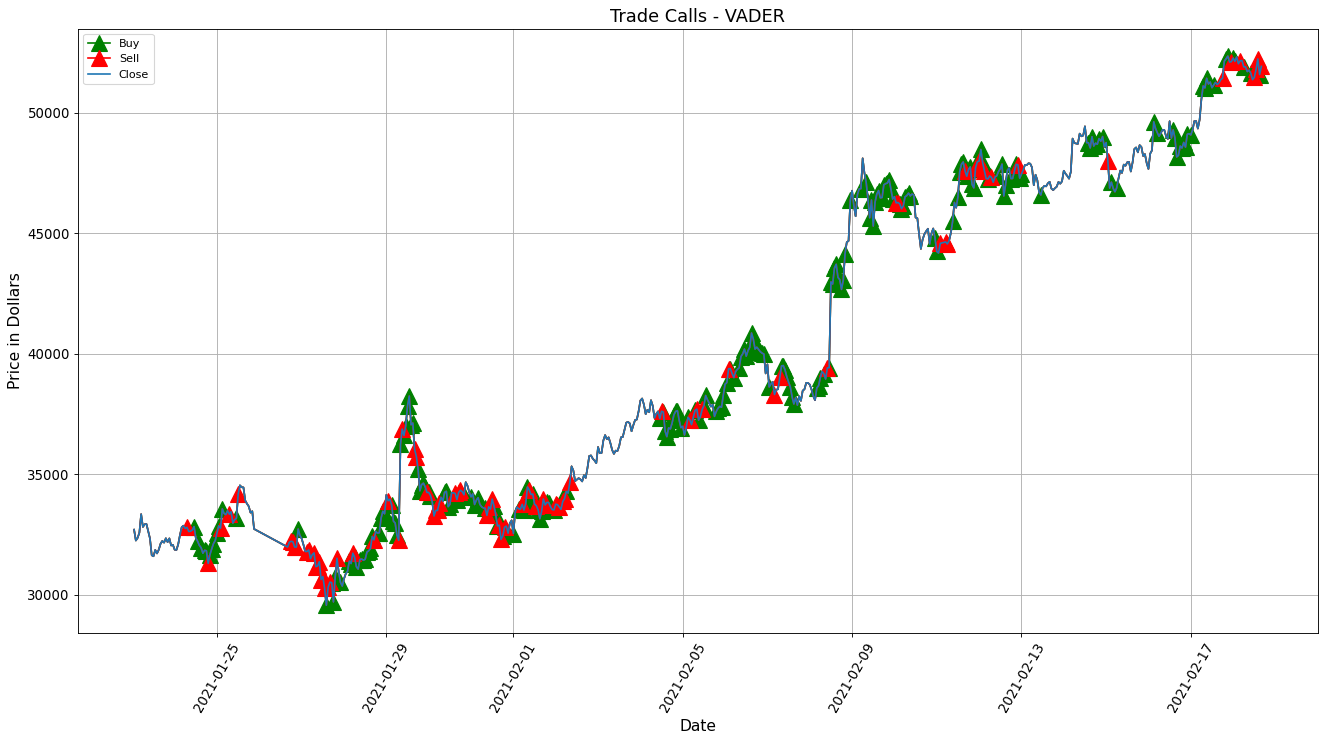

In [6]:
def main():
    """
    Main function
    :return: None
    """
    trading_symbol = 'BTC'
    trade_caller = TradeCalls()
    database_client = DatabaseClient()

    overall_headlines = database_client.read_db()
    
    time = pd.to_datetime(overall_headlines.date, infer_datetime_format=True) + overall_headlines.hour.astype('timedelta64[h]')
    overall_headlines['publishedAt'] = time
    
    df = trade_caller.calculate_extreme_scores(overall_headlines, trading_symbol)
    df['dateid'] = df['Date'].dt.strftime('%d/%m/%Y')
    df['timeid'] = df['Date'].dt.hour
    df['trading_symbol'] = trading_symbol
    
    database_client.insert_db(df)
    
    sentiment_Buy, sentiment_Sell = trade_caller.make_trade_call(df)

    trade_caller.vizualise_calls(trading_symbol, sentiment_Buy, sentiment_Sell)


if __name__ == "__main__":
    main()